In [1]:
from IPython import display
from ipywidgets import Image

import os
import datajoint as dj

In [ ]:
schema.drop()

In [3]:
schema = dj.schema('dimitri_filepath')

In [4]:
dj.list_schemas()

['dimitri_alter',
 'dimitri_attach',
 'dimitri_blob',
 'dimitri_blobs',
 'dimitri_filepath',
 'dimitri_nphoton',
 'dimitri_nwb',
 'dimitri_schema',
 'dimitri_test',
 'dimitri_university',
 'dimitri_uuid',
 'test_attach',
 'test_filepath',
 'test_mikkel',
 'test_orders',
 'test_parse',
 'test_question001',
 'test_question002',
 'university']

In [5]:
## Storage configuration

# set up stores
dj.config['stores'] = {
    'remote': dict(   # store in minio
        stage=os.path.abspath('./stage'),
        protocol='s3',
        endpoint='localhost:9000',
        access_key='datajoint',
        secret_key='datajoint',
        bucket='datajoint-demo',        
        location='dj/file-demo'),   
    }

## Download some images off the web into ./stage

In [6]:
# Step 1: Find a bunch of images on the web
logos = dict(
    ucsd='https://upload.wikimedia.org/wikipedia/commons/f/f6/UCSD_logo.png',
    datajoint='https://datajoint.io/static/images/DJiotitle.png',
    utah='https://umc.utah.edu/wp-content/uploads/sites/15/2015/01/Ulogo_400p.png',
    bcm='https://upload.wikimedia.org/wikipedia/commons/5/5d/Baylor_College_of_Medicine_Logo.png',
    pydata='https://pydata.org/wp-content/uploads/2018/10/pydata-logo.png',
    python='https://www.python.org/static/community_logos/python-logo-master-v3-TM.png',
    pni='https://vathes.com/2018/05/24/Princeton-Neuroscience-Institute-Partners-with-Vathes-to-Support-the-Adoption-of-DataJoint/PNI%20logo.png')

In [7]:
Image.from_url(logos['python'])

Image(value=b'https://www.python.org/static/community_logos/python-logo-master-v3-TM.png', format='url')

In [8]:
@schema
class Organization(dj.Lookup):
    definition = """
    organization : varchar(30)
    --- 
    logo_url : varchar(255)
    """
    contents = logos.items()

In [9]:
Organization()

organization,logo_url
bcm,https://upload.wikimedia.org/wikipedia/commons/5/5d/Baylor_College_of_Medicine_Logo.png
datajoint,https://datajoint.io/static/images/DJiotitle.png
pni,https://vathes.com/2018/05/24/Princeton-Neuroscience-Institute-Partners-with-Vathes-to-Support-the-Adoption-of-DataJoint/PNI%20logo.png
pydata,https://pydata.org/wp-content/uploads/2018/10/pydata-logo.png
python,https://www.python.org/static/community_logos/python-logo-master-v3-TM.png
ucsd,https://upload.wikimedia.org/wikipedia/commons/f/f6/UCSD_logo.png
utah,https://umc.utah.edu/wp-content/uploads/sites/15/2015/01/Ulogo_400p.png


In [10]:
import requests 

@schema
class Logo(dj.Imported):
    definition = """
    -> Organization
    ---
    logo_image : filepath@remote
    """
    
    path = os.path.join(dj.config['stores']['remote']['stage'], 'organizations', 'logos')
    
    def make(self, key):
        # create the subfolder and download the logo into local_file 
        os.makedirs(self.path, exist_ok=True)
        url = (Organization & key).fetch1('logo_url')
        local_file = os.path.join(self.path, key['organization'] + os.path.splitext(url)[1])
        print(local_file)
        with open(local_file, 'wb') as f:
            f.write(requests.get(url).content)
        # sync up
        self.insert1(dict(key, logo_image=local_file))        

In [11]:
Logo.populate()

/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/bcm.png
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/datajoint.png
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/pni.png
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/pydata.png
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/python.png
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/ucsd.png
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/utah.png


In [12]:
Logo()

organization,logo_image
pydata,=BLOB=
utah,=BLOB=
datajoint,=BLOB=
ucsd,=BLOB=
pni,=BLOB=
python,=BLOB=
bcm,=BLOB=


In [13]:
Logo.fetch(as_dict=True)

[{'organization': 'pydata',
  'logo_image': '/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/pydata.png'},
 {'organization': 'utah',
  'logo_image': '/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/utah.png'},
 {'organization': 'datajoint',
  'logo_image': '/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/datajoint.png'},
 {'organization': 'ucsd',
  'logo_image': '/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/ucsd.png'},
 {'organization': 'pni',
  'logo_image': '/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/pni.png'},
 {'organization': 'python',
  'logo_image': '/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/python.png'},
 {'organization': 'bcm',
  'logo_image': '/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/bcm.png'}]

In [14]:
# delete the local repository completely
import shutil
shutil.rmtree(dj.config['stores']['remote']['stage'])

In [15]:
paths = Logo().fetch('logo_image')

In [16]:
paths

array(['/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/pydata.png',
       '/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/utah.png',
       '/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/datajoint.png',
       '/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/ucsd.png',
       '/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/pni.png',
       '/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/python.png',
       '/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/bcm.png'],
      dtype=object)

In [17]:
Image.from_file(paths[4])

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xfb\x00\x00\x00\xc9\x08\x03\x00\x00\x00\xd2\x1e\…

In [18]:
(Logo & 'organization in ("datajoint", "bcm")').delete()

About to delete:
`dimitri_filepath`.`_logo`: 2 items
Proceed? [yes, No]: yes
Committed.


In [19]:
ext = schema.external['remote']

In [20]:
ext

"hash hash of contents (blob), of filename + contents (attach), or relative filepath (filepath)",size size of object in bytes,filepath relative filepath used in the filepath datatype,contents_hash used for the filepath datatype,timestamp automatic timestamp
3fd4b79b-9fdd-95c0-4074-68614d97f7e1,162,organizations/logos/pydata.png,bc56979a-0b38-1a79-1dd5-9713198a87fb,2019-07-30 16:50:40
56c820a9-e83c-02c9-8e76-7ba908192588,13216,organizations/logos/utah.png,1c755e4b-a65f-5576-352e-729f0c5987da,2019-07-30 16:50:41
6e7ba0be-2171-a2ab-163e-ff12b0943e8e,36444,organizations/logos/datajoint.png,9e902f2f-726a-2da5-0a24-ee3b97892f8a,2019-07-30 16:50:38
81dc7dae-bebc-6d38-b891-c48eee8e340a,33734,organizations/logos/ucsd.png,914f5b55-ea69-7489-d45b-031bec3ecaa5,2019-07-30 16:50:40
8c25c65d-506d-f382-0e36-88e1f6057ea3,6293,organizations/logos/pni.png,0d59845d-5c75-24f8-20c8-9637517ed6a7,2019-07-30 16:50:39
f35b5a91-38cb-bc7f-ef17-b2ce94bb0131,83564,organizations/logos/python.png,3cf229ee-dc09-2549-277e-8859aad2fca5,2019-07-30 16:50:40
f97ea212-5794-926a-d852-deffc0f10bba,227965,organizations/logos/bcm.png,10ee4617-a63f-61ba-2807-35a266a9f488,2019-07-30 16:50:38


In [21]:
ext.delete()

Deleted 2 items


In [22]:
ext.clean_blobs()

Deleting...
  Deleted: 0 S3 objects; 0 failed.


In [23]:
list(ext.get_untracked_filepaths())

['dj/file-demo/organizations/logos/bcm.png',
 'dj/file-demo/organizations/logos/datajoint.png']

In [24]:
states = dict(
    AL='Alabama',        AK='Alaska',       AZ='Arizona',      AR='Arkansas',
    CA='California',     CO='Colorado',     CT='Connecticut',  DE='Delaware',
    FL='Florida',        GA='Georgia',      HI='Hawaii',       ID='Idaho', 
    IL='Illinois',       IN='Indiana',      IA='Iowa',         KS='Kansas',
    KY='Kentucky',       LA='Louisiana',    ME='Maine',        MD='Maryland',
    MA='Massachusetts',  MI='Michigan',     MN='Minnesota',    MS='Mississippi',
    MO='Missouri',       MT='Montana',      NE='Nebraska',     NV='Nevada',
    NH='New Hampshire',  NJ='New Jersey',   NM='New Mexico',   NY='New York',
    NC='North Carolina', ND='North Dakota', OH='Ohio',         OK='Oklahoma',
    OR='Oregon',         PA='Pennsylvania', RI='Rhode Island', SC='South Carlina',
    SD='South Dakota',   TN='Tennessee',    TX='Texas',        UT='Utah',
    VT='Vermont',        VA='Virginia',     WA='Washington',   WV='West Virginia', 
    WI='Wisconsin',      WY='Wyoming')

In [25]:
@schema
class State(dj.Lookup):
    definition = """
    # United States
    state_code : char(2)
    ---
    state : varchar(20)
    """
    contents = states.items()

In [26]:
State()

state_code,state
AK,Alaska
AL,Alabama
AR,Arkansas
AZ,Arizona
CA,California
CO,Colorado
CT,Connecticut


In [27]:
@schema
class StateBird(dj.Imported):
    definition = """
    -> State
    ---
    bird_image : filepath@remote    
    """
    path = os.path.join(dj.config['stores']['remote']['stage'], 'states', 'birds')
    
    
    def make(self, key):
        os.makedirs(self.path, exist_ok=True)
        state = (State & key).fetch1('state')
        url = "http://www.theus50.com/images/state-birds/{state}-bird.jpg".format(state=state.lower())
        local_file = os.path.join(self.path, state.lower() + os.path.splitext(url)[1])
        print(local_file)
        with open(local_file, 'wb') as f:
            f.write(requests.get(url).content)
        self.insert1(dict(key, bird_image=local_file))        


In [28]:
StateBird.populate()

/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/alaska.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/alabama.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/arkansas.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/arizona.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/california.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/colorado.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/connecticut.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/delaware.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/florida.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/georgia.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/hawaii.jpg
/home/dimitri

In [29]:
@schema
class StateFlower(dj.Imported):
    definition = """
    -> State
    ---
    flower_image : filepath@remote    
    """
    path = os.path.join(dj.config['stores']['remote']['stage'],'states', 'flowers')
    
    
    def make(self, key):
        os.makedirs(self.path, exist_ok=True)
        state = (State & key).fetch1('state')
        url = "http://www.theus50.com/images/state-birds/{state}-flower.jpg".format(state=state.lower())
        local_file = os.path.join(self.path, state.lower() + os.path.splitext(url)[1])
        print(local_file)
        with open(local_file, 'wb') as f:
            f.write(requests.get(url).content)
        self.insert1(dict(key, flower_image=local_file))     

In [30]:
StateFlower().populate()

/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/alaska.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/alabama.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/arkansas.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/arizona.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/california.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/colorado.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/connecticut.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/delaware.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/florida.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/georgia.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/ha

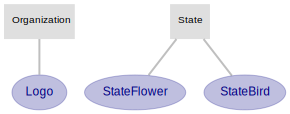

In [31]:
dj.Diagram(schema)

In [ ]:
@schema
class Table(dj.Manual):
    definition = """
    table : int
    ---
    legs : int
    area : float
    """

In [ ]:
Table.insert1((3, 8, 1002.4))

In [ ]:
Table.proj(..., load = 'area/legs').fetch('legs', 'load', as_dict=True)